#### Import Libraries

In [1]:
import tweepy
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Set Up Twitter API

In [3]:
# Authenticate Twitter API
API_KEY = "wfXbapudLTPDJ9gZjdKIJppTV"
API_SECRET = "C55zVwlHmJNtlXUqGYzMmiHhk1FdPyy6KM3owoD0AvSvoMi12w"
ACCESS_TOKEN = "1540206983005216769-WhQknWGuqYzQ3IX7jaynARPiiS2Eu1"
ACCESS_SECRET = "IN5dRMEz4Kse99zZMKGBFpm1RjAhHXjMqI5EYy3ojJ0RB"

auth = tweepy.OAuth1UserHandler(API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

#### Data Scraping

In [4]:
import time
import pandas as pd
import tweepy

# Assuming the client is authenticated as follows:
client = tweepy.Client(bearer_token = "AAAAAAAAAAAAAAAAAAAAAGBKxQEAAAAARrQqHqNcAeLFMW4ejtEl6CSPGWQ%3DgwZSGBdeMRDwa4hmUO5PdXA3atxmWxAMmIQaZfqh5CqsJN6Gn4")

def fetch_tweets_v2(keyword, count = 100):
    query = f"{keyword} lang: en"
    tweets = []
    try:
        # Request tweets
        response = client.search_recent_tweets(query = query, max_results = min(count, 100))
        if response.data:
            tweets.extend([tweet.text for tweet in response.data])
        time.sleep(1)  # Delay between requests to avoid rate limits
    except tweepy.TooManyRequests:
        print("Rate limit exceeded. Waiting for 2 minutes...")
        time.sleep(2 * 60)  # Wait for 5 minutes
    return pd.DataFrame(tweets, columns = ["Tweet"])

# Example usage
stock_data = fetch_tweets_v2(keyword = "Stock Market", count = 10)
print(stock_data.head())

                                               Tweet
0  @Soaringeagle45 @cox_kandi61354 Here you go \n...
1  @nid_rockz For these type of futuristic growth...
2  RT @KobeissiLetter: The US stock market is MAS...
3  RT @KobeissiLetter: The US stock market is MAS...
4  RT @TrackInsiders_: Rep. Dan Crenshaw went on ...


#### Data Cleaning and Sentiment Analysis

In [5]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# Download required NLTK resources
nltk.download("stopwords")
nltk.download("punkt")  # Punkt tokenizer
nltk.download('punkt_tab') 

# Set up stop words
stop_words = set(stopwords.words("english"))

# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags = re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r"\@\w+|\#", "", text)
    # Remove special characters and punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word not in stop_words])

# Function to analyze sentiment
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Example dataset
data = {"Tweet": ["I love the stock market! #investing", 
                  "The market is crashing, terrible day!", 
                  "Stocks are unpredictable but interesting.",
                  "What a bullish trend today!", 
                  "The bearish trend is concerning."]}
stock_data = pd.DataFrame(data)

# Apply cleaning and sentiment analysis
stock_data["Cleaned_Tweet"] = stock_data["Tweet"].apply(clean_text)
stock_data["Sentiment"] = stock_data["Cleaned_Tweet"].apply(analyze_sentiment)

# Display the results
print(stock_data)

                                       Tweet  \
0        I love the stock market! #investing   
1      The market is crashing, terrible day!   
2  Stocks are unpredictable but interesting.   
3                What a bullish trend today!   
4           The bearish trend is concerning.   

                      Cleaned_Tweet  Sentiment  
0       love stock market investing   0.500000  
1      market crashing terrible day  -1.000000  
2  stocks unpredictable interesting   0.166667  
3               bullish trend today   0.000000  
4          bearish trend concerning   0.000000  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ombha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ombha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ombha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Machine Learning Model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Simulate sentiment labels: 1 for positive stock movement, 0 for negative
stock_data["Label"] = (stock_data["Sentiment"] > 0).astype(int)

# Feature extraction
X = stock_data["Cleaned_Tweet"]
y = stock_data["Label"]

# Convert text data into a matrix of token counts (Bag-of-Words)
vectorizer = CountVectorizer(max_features = 5000)
X_vectorized = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size = 0.2, random_state = 42)

# Use SMOTE to balance the dataset (if needed)
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the model with class_weight='balanced' to handle imbalance
model = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_pred = model.predict(X_test)

# Print classification report for model evaluation
print(classification_report(y_test, y_pred))

# Evaluate with F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Precision-Recall curve (to evaluate model performance in imbalanced settings)
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
print("Precision-Recall curve:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

F1 Score: 0.0
Precision-Recall curve:
Precision: [0. 1.]
Recall: [1. 0.]


#### Evaluate Model

In [7]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.0
Confusion Matrix:
[[0 1]
 [0 0]]


#### Visualize Sentiment

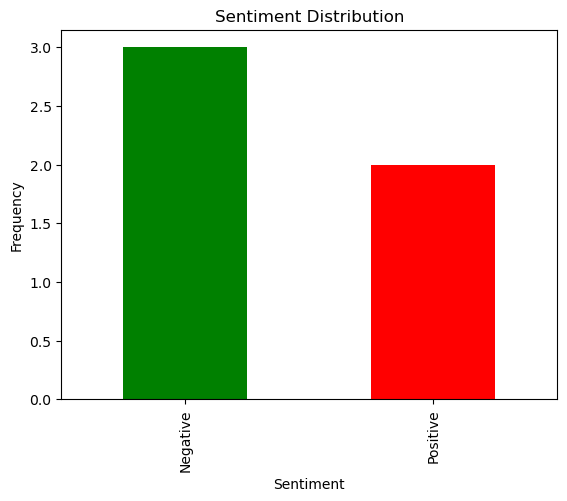

In [8]:
import matplotlib.pyplot as plt

stock_data["Sentiment_Label"] = stock_data["Sentiment"].apply(lambda x: "Positive" if x > 0 else "Negative")

sentiment_counts = stock_data["Sentiment_Label"].value_counts()
sentiment_counts.plot(kind="bar", color = ["green", "red"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()